In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
from PIL import Image
import cv2
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch
import pandas as pd
# manual start: pymol/start.sh -R
import xmlrpc.client as xmlrpclib

In [2]:
sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line
            sid = ''
mat3di = jnp.load('data/mat3di.npy') * 1.4
blosum = jnp.load('data/blosum62.npy') * 2.1
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return jnp.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = jnp.array(jnp.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = jnp.array(jnp.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S
def distances(q_points_aln, t_points_aln):
    d_mat = cdist(q_points_aln, t_points_aln)
    return (d_mat)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
coord_dir = 'data/pdb/d*'
if not os.path.exists(coord_dir):
    print('Creating cache first.')
    sautils.encoder_commons.init_coords('data/pdb/d*', coord_dir)
sid2coords = {sid: sautils.encoder_commons.read_coords(coord_dir, sid) for sid in sautils.encoder_commons.list_sids(coord_dir)}

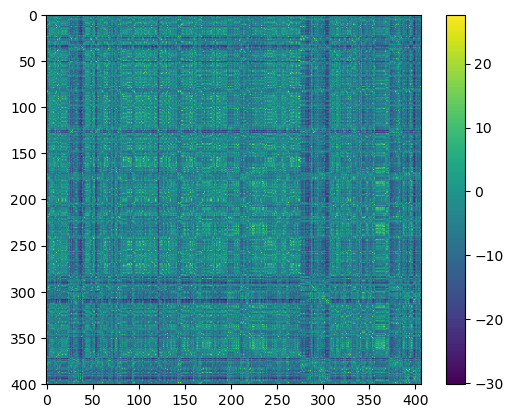

In [4]:
query = 'd1dkza1'
target = 'd2p06a1'
query, target = "d1q5da_","d3awma_"

#query, target = "d1v58a2", "d1v04a_"
qt_swap = False
#if len(sid2seq_aa[query]) >= len(sid2seq_aa[target]):
#    query, target = target, query
#    qt_swap = True

aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)

im = plt.imshow(S)
plt.colorbar(im)
plt.show()
example_alignment = {'query': query,
                     'target': target,
                     'cigar': '9M1D11M2I10M1D2M6I8M8I15M6D3M1D3M4D9M',
                     'qstart': 12,
                     'tstart': 9}
coords1,_ = sid2coords.get(example_alignment['query'])
coords2,_ = sid2coords.get(example_alignment['target'])
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = jnp.asarray(d_mat_ij)
d_mat_kl = jnp.asarray(d_mat_kl)

In [5]:
def sw(unroll=2, batch=True, NINF=-1e30):
  '''smith-waterman (local alignment) with gap parameter'''

  # rotate matrix for striped dynamic-programming
  def rotate(x):   
    # solution from jake vanderplas (thanks!)
    a,b = x.shape
    ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
    i,j = (br-ar)+(a-1),(ar+br)//2
    n,m = (a+b-1),(a+b)//2
    output = {"x":jnp.full([n,m],NINF).at[i,j].set(x), "o":(jnp.arange(n)+a%2)%2}
    return output, (jnp.full(m, NINF), jnp.full(m, NINF)), (i,j)

  # compute scoring (hij) matrix
  def sco(x, lengths, gap=0, temp=1.0):

    def _soft_maximum(x, axis=None, mask=None):
      def _logsumexp(y):
        y = jnp.maximum(y,NINF)
        if mask is None: return jax.nn.logsumexp(y, axis=axis)
        else: return y.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(y - y.max(axis, keepdims=True)), axis=axis))
      return temp*_logsumexp(x/temp)
    
    def _cond(cond, true, false): return cond*true + (1-cond)*false
    def _pad(x,shape): return jnp.pad(x,shape,constant_values=(NINF,NINF))

    def _step(prev, sm):      
      h2,h1 = prev   # previous two rows of scoring (hij) mtx
      h1_T = _cond(sm["o"],_pad(h1[:-1],[1,0]),_pad(h1[1:],[0,1]))
      
      # directions
      Align = h2 + sm["x"]
      Turn_0 = h1 + gap
      Turn_1 = h1_T + gap
      Sky = sm["x"]

      h0 = jnp.stack([Align, Turn_0, Turn_1, Sky], -1)
      h0 = _soft_maximum(h0, -1)
      return (h1,h0),h0

    # mask
    a,b = x.shape
    real_a, real_b = lengths
    mask = (jnp.arange(a) < real_a)[:,None] * (jnp.arange(b) < real_b)[None,:]
    x = x + NINF * (1 - mask)

    sm, prev, idx = rotate(x[:-1,:-1])
    hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]
    return _soft_maximum(hij + x[1:,1:], mask=mask[1:,1:])

  # traceback (aka backprop) to get alignment
  traceback = jax.grad(sco)

  # add batch dimension
  if batch: return jax.vmap(traceback,(0,0,None,None))
  else: return traceback


fused_model = torch.load('data/distance_model_integrated_1.torch')

w_list = [fused_model[i].weight.detach().numpy() for i in [0, 2, 4, 6, 8]]
bias_list = [fused_model[i].bias.detach().numpy() for i in [0, 2, 4, 6, 8]]



def lol_score_jax(d_ij, d_kl, d_seq):    
    x = jnp.stack(
        [jnp.log(d_ij/d_kl),
         jnp.log(d_ij),
         jnp.log(d_kl),
         jnp.sign(d_seq) * jnp.log(1 + jnp.abs(d_seq)),
        ],
        axis=-1)
    # NN
    for w, bias in zip(w_list[:-1], bias_list[:-1]):
        x = jax.nn.relu((x @ w.T) + bias)
    x = (x @ w_list[-1].T) + bias_list[-1]  # last layer has no ReLU
    p = jax.nn.sigmoid(x)
    # Probabilities to log odd scores
    score = jnp.log(p / (1-p)).reshape(-1)
    return score

In [6]:
def distances_ij(q_points_aln, t_points_aln, cutoff=15):
    """intra-molecular distances with cutoff"""
    d_ij = np.sqrt(np.sum((q_points_aln[:, None] - q_points_aln[None, :])**2, axis=-1))
    d_kl = np.sqrt(np.sum((t_points_aln[:, None] - t_points_aln[None, :])**2, axis=-1))

    neighbor_mask = (d_ij < cutoff).astype(np.float32) * (1. - np.eye(len(d_ij)))
    return (neighbor_mask * d_ij, neighbor_mask * d_kl)

def distances_mn(coords, mask):
    """Intra-molecular distances between all residues.
       Residue coords can be NaN.
    """
    d_mn = np.sqrt(np.sum((coords[:, None] - coords[None, :])**2, axis=-1))
    d_mn[~mask, :] = 0
    d_mn[:, ~mask] = 0
    return d_mn

def align_coords(query, target, alignment):
    coords1, mask1 = query
    coords2, mask2 = target
    cigar, q_start, t_start = alignment

    idx1, idx2 = sautils.common.parse_cigar(cigar, query=q_start, ref=t_start, include_m=True, order_qt=True).T

    # Remove masked residues from alignment
    mask = mask1[idx1] & mask2[idx2]
    aln_coords1 = coords1[idx1, :3][mask]  # need only CA
    aln_coords2 = coords2[idx2, :3][mask]    
    return (aln_coords1, aln_coords2), (idx1, idx2), (len(coords1), len(coords2))

def aligned_distance_mats(aln, load_coords_fn):
    coords1, mask1 = load_coords_fn(aln['query'])
    coords2, mask2 = load_coords_fn(aln['target'])
    
    (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) = align_coords((coords1, mask1), (coords2, mask2), (aln['cigar'], aln['qstart'], aln['tstart']))
    
    d_mat_ij, d_mat_kl = distances_ij(aln_coords1, aln_coords2)  # intra-molecular distances between *aligned* resdiues of query and target
    d_mat_seq = idx1[None, :] - idx1[:, None]  # sequence distance between *aligned* query residues
    d_mat_mn = distances_mn(coords1[:, 0:3], mask1)  # intra-molecular distances between *all* query residues
    return d_mat_ij, d_mat_kl, d_mat_seq, d_mat_mn, (idx1, idx2, len1, len2)

In [7]:
#temp = np.load("data/100Scores_fixed/"+query+"-"+target+".npy")
S = np.load("temp.npy")
sw_app = sw(batch=False)
P = sw_app(S,(S.shape), gap=-5, temp=10)

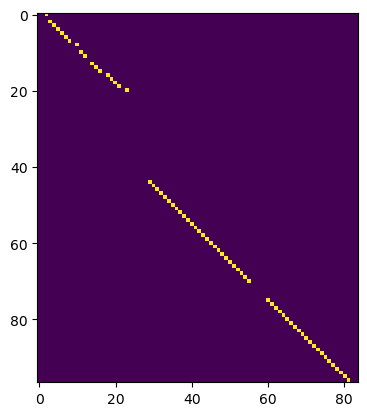

In [8]:
plt.imshow(P)

In [9]:
A = np.zeros_like(P)

In [465]:

for i in tqdm(range(1,P.shape[0])):
    for j in (range(1,P.shape[1])):    
        A[i,j] = max(A[i-1,j-1]+P[i,j]-0.35,A[i-1,j], A[i,j-1], 0)

100%|█████████████████████████████████████████| 119/119 [00:17<00:00,  6.90it/s]


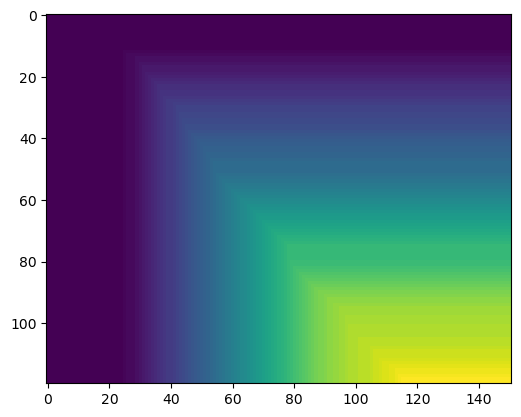

In [466]:
plt.imshow(A)

In [7]:

AL = np.zeros_like(A)
i,j = np.unravel_index(A.argmax(), A.shape)
while i != 0 and j != 0:
    A = np.zeros_like(P)
    max_idx = np.argmax([A[i-1,j-1], A[i-1,j], A[i,j-1]])
    if max_idx == 0:
        AL[i-1,j-1] = 1
        i -= 1
        j-= 1
        if A[i,j] == 0:
            break
    elif max_idx == 1:
        AL[i-1, j] = 0
        i-=1
    elif max_idx == 2:
        AL[i,j-1] = 0
        j-=1
        

NameError: name 'A' is not defined

In [ ]:
def calc_fixed_al(P):
    A = np.zeros_like(P)
    for i in (range(1,P.shape[0])):
        for j in (range(1,P.shape[1])):    
            A[i,j] = max(A[i-1,j-1]+P[i,j]-0.35,A[i-1,j], A[i,j-1], 0)
    AL = np.zeros_like(A)
    i,j = np.unravel_index(A.argmax(), A.shape)
    while i != 0 and j != 0:
        max_idx = np.argmax([A[i-1,j-1], A[i-1,j], A[i,j-1]])
        if max_idx == 0:
            AL[i-1,j-1] = 1
            i -= 1
            j-= 1
            if A[i,j] == 0:
                break
        elif max_idx == 1:
            AL[i-1, j] = 0
            i-=1
        elif max_idx == 2:
            AL[i,j-1] = 0
            j-=1
    return AL
    

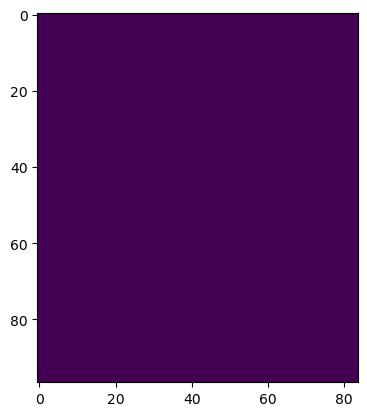

In [17]:
plt.imshow(AL)

In [18]:
np.unravel_index(A.argmax(), A.shape)

(0, 0)

In [8]:
def lddt_multidomain_new(d_ij, d_kl, d_mn, idx1, cutoff):
    d = np.abs(d_kl - d_ij)

    score = 0.25 * ((d < 0.5).astype(np.float32) +
                    (d < 1.0).astype(np.float32) +
                    (d < 2.0).astype(np.float32) +
                    (d < 4.0).astype(np.float32))

    # Note: 0 is used to masked distances
    neighbor_mask = ((0 < d_ij) & (d_ij < cutoff)).astype(np.float32) * (1. - np.eye(len(d_ij)))
 
    score_per_residue = np.sum(neighbor_mask * score, axis=-1)
    norm_per_residue = np.sum((0 < d_mn) & (d_mn < cutoff), axis=-1)[idx1]

    return np.mean(score_per_residue / norm_per_residue), (neighbor_mask * score, norm_per_residue)

# From distance matrix to alignment score
def lddt_score_new(aln, load_coords_fn, AL):
    d_mat_ij, d_mat_kl, d_mn, idx1 = aligned_distance_mats_new(aln, load_coords_fn, AL)
    return lddt_multidomain_new(d_mat_ij, d_mat_kl, d_mn, idx1, 15)
def aligned_distance_mats_new(aln, load_coords_fn, AL, th=0.5):
    coords1,mask1 = sid2coords.get(aln['query'])
    coords2,mask2 = sid2coords.get(aln['target'])
    d_mat_ij = distances(coords1[:,:3], coords1[:,:3])
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2[:,:3], coords2[:,:3])
    
    idx1 = np.arange(d_mat_ij.shape[0])
    
    index_temp = np.argwhere(np.sum(AL > th,axis = 1) == 0)

    d_mat_ij_test = np.delete(d_mat_ij, index_temp, axis = 1)
    d_mat_ij_test = np.delete(d_mat_ij_test, index_temp, axis = 0)
    idx1 = np.delete(idx1, index_temp[:,0], 0)
    
    
    index_temp = np.argwhere(np.sum(AL > th,axis = 0) == 0)
    d_mat_kl_test = np.delete(d_mat_kl, index_temp, axis = 0)
    d_mat_kl_test = np.delete(d_mat_kl_test, index_temp, axis = 1)
    
    

    # sequence distance between *aligned* query residues
    d_mat_mn = distances_mn(coords1[:, 0:3], mask1)  # intra-molecular distances between *all* query residues
    return d_mat_ij_test, d_mat_kl_test, d_mat_mn, idx1
#lddt_score_new(example_alignment, sid2coords.get, P)

In [9]:
def aligned_distance_mats(aln, load_coords_fn):
    coords1, mask1 = load_coords_fn(aln['query'])
    coords2, mask2 = load_coords_fn(aln['target'])
    
    (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) = align_coords((coords1, mask1), (coords2, mask2), (aln['cigar'], aln['qstart'], aln['tstart']))
    d_mat_ij, d_mat_kl = distances_ij(aln_coords1, aln_coords2)  # intra-molecular distances between *aligned* resdiues of query and target
    d_mat_seq = idx1[None, :] - idx1[:, None]  # sequence distance between *aligned* query residue
    d_mat_mn = distances_mn(coords1[:, 0:3], mask1)  # intra-molecular distances between *all* query residues
    return d_mat_ij, d_mat_kl, d_mat_seq, d_mat_mn, (idx1, idx2, len1, len2)
def lddt_multidomain(d_ij, d_kl, d_mn, idx1, cutoff):
    d = np.abs(d_kl - d_ij)

    score = 0.25 * ((d < 0.5).astype(np.float32) +
                    (d < 1.0).astype(np.float32) +
                    (d < 2.0).astype(np.float32) +
                    (d < 4.0).astype(np.float32))

    # Note: 0 is used to masked distances
    neighbor_mask = ((0 < d_ij) & (d_ij < cutoff)).astype(np.float32) * (1. - np.eye(len(d_ij)))
 
    score_per_residue = np.sum(neighbor_mask * score, axis=-1)
    norm_per_residue = np.sum((0 < d_mn) & (d_mn < cutoff), axis=-1)[idx1]

    return np.mean(score_per_residue / norm_per_residue), (neighbor_mask * score, norm_per_residue)

# From distance matrix to alignment score
def lddt_score(aln, load_coords_fn):
    d_mat_ij, d_mat_kl, _, d_mn, (idx1, _, _, _) = aligned_distance_mats(aln, load_coords_fn)
    return lddt_multidomain(d_mat_ij, d_mat_kl, d_mn, idx1, 15)

In [12]:
(aligned_distance_mats_new(example_alignment, sid2coords.get, fixed_al)[1])

NameError: name 'fixed_al' is not defined

In [10]:
alignments = pd.read_csv("benchmark/sample_alignments.csv")
alignments.sample(100, random_state=42)
data = alignments[alignments['lolscore_lol_lbfgsb_success']]
data = alignments
data#[data["query"] == "d1v58a2"]

,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,...,qstart_dali,tstart_dali,cigar_dali,dali_rank,lolscore_dali,lolscore_fs,lolscore_lol_fixed,lolscore_lol_lbfgsb,lolscore_lol_lbfgsb_success,lolscore_anchor
0,0,7185,d1bd0a2,d1ykwa1,61,0.3718,8M2D14M1I14M3D6M10D10M8D27M7D6M2D11M2I11M3D21M...,10,7,246,...,2,1,29M2D24M2D4M4D5M1I4M14D5M1I15M6D7M3D7M4I12M6I4...,145,2912.069336,1039.918213,2929.961426,3101.256991,True,3071.246826
1,1,9019,d1bm9a_,d1ku9a_,39,0.4445,8M2I28M5I10M6I19M,41,46,78,...,1,11,28M2D12M9I26M5I16M13D24M,123,-692.045227,146.618561,560.031433,839.756596,True,834.455627
2,2,11243,d1c4oa1,d1oywa2,50,0.4305,15M5I48M2I11M4I2M21I13M1D6M1I4M71I2M8I8M12I7M2...,8,25,328,...,1,3,4M13D8M2I14M1I46M2I11M25I31M95I6M2D13M7D6M29I9...,9,4486.741699,2997.943848,5632.099609,1889.544731,True,5671.757812
3,3,19877,d1dkza1,d2p06a1,27,0.5078,10M1D8M6D4M1D41M,31,8,71,...,16,1,82M,273,-226.221375,-7.789455,252.211395,439.874062,True,399.331787
4,4,21931,d1dvoa_,d1s35a1,13,0.3393,13M4D11M2I13M2D17M3I9M17I14M3I10M,39,2,118,...,1,14,41M51I5M2I5M1D4M13I31M,48,137.838470,-892.626770,-49.812542,331.485053,True,283.349335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,344737,d3irua_,d2w43a_,98,0.4652,13M7D16M13I13M6I9M3I11M8I3M1I9M2I32M1I31M3I25M...,14,2,264,...,13,1,16M3D7M22D11M48I14M1I7M1I8M1I11M3I13M2D30M3I27...,44,4616.894043,3447.175537,5635.312500,5836.913727,True,5285.364746
96,96,349671,d3m94a_,d1sc6a3,42,0.3697,13M10I5M1I27M2I18M3I2M2I9M,76,11,92,...,54,1,4M7I5M5I9M7I4M2I7M2I30M2I18M3I7M,24,1277.434814,682.383057,1455.606812,1478.339325,True,1046.984131
97,97,349849,d3ma2b_,d1n9wa1,33,0.3625,9M1D11M2I10M1D2M6I8M8I15M6D3M1D3M4D9M,12,9,99,...,2,1,24M1I5M2I10M5I9M6I4M1I4M1I11M7D5M3I7M11I7M,37,762.580078,102.951736,1207.911133,1017.300759,True,996.043640
98,98,359460,d3t0ha_,d2hkja3,123,0.4256,4M4D11M1D16M1I2M12I10M3D5M2D23M11I7M2D12M4D7M1...,12,4,223,...,12,1,10M1D5M7D19M13I12M5D21M4I11M5I20M5D11M1D9M5D4M...,5,4263.217773,2510.592285,4352.616211,4548.853023,True,4347.911621


In [11]:
query, target = "d1v58a2", "d1v04a_"
coords1,_ = sid2coords.get(example_alignment['query'])
coords2,_ = sid2coords.get(example_alignment['target'])
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = jnp.asarray(d_mat_ij)
d_mat_kl = jnp.asarray(d_mat_kl)

0.25599916171007464


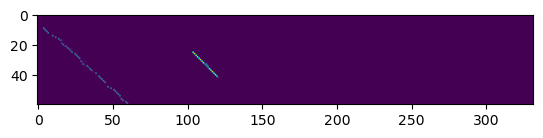

In [12]:


example_alignment = {'query': query,
                     'target': target,
                     'cigar': 0,
                     'qstart': 0,
                     'tstart': 0}
S = np.load("data/100ScoresLBFGSB/"+query+"-"+target+".npy")
#S = np.load("res_lbfgsb.npy")
sw_app = sw(batch=False)
P = sw_app(S,(S.shape), gap=-5, temp=1)
#P = calc_fixed_al(P)
print(lddt_score_new(example_alignment, sid2coords.get, P)[0])
plt.imshow(P)

In [13]:
example_alignment = {'query': query,
                    'target': target,
                    'cigar': data[data["query"] == query]['cigar_dali'].values[0] ,
                    'qstart': data[data["query"] == query]['qstart_dali'].values[0] ,
                    'tstart': data[data["query"] == query]['tstart_dali'].values[0] }


lddt_score(example_alignment, sid2coords.get)[0]

0.617480476187867

In [14]:
data[data["query"] == query]['cigar_dali'].values[0]

'23M4D22M4D8M48D7M'

In [15]:
P_fixed = np.copy(P)

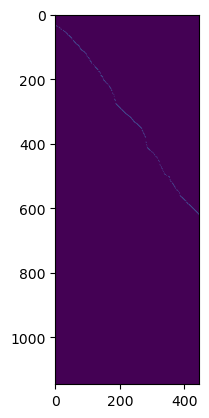

In [67]:
#query, target = 'd1ry9a_' ,'d3fpqa_'
example_alignment = {'query': query,
                     'target': target,
                     'cigar': 0,
                     'qstart': 0,
                     'tstart': 0}
S = np.load("data/100Scores_fixed/"+query+"-"+target+".npy")
sw_app = sw(batch=False)
P = sw_app(S,(S.shape), gap=-5, temp=1)
plt.imshow(P)

In [15]:
for i in (range(100)):
    q,t = data['query'][i], data['target'][i]
    example_alignment = {'query': q,
                     'target': t,
                     'cigar': data['cigar_fs'][i],
                     'qstart': data['qstart_fs'][i],
                     'tstart': data['tstart_fs'][i]}
    S = np.load("data/100Scores_fixed/"+q+"-"+t+".npy")
    sw_app = sw(batch=False)
    P = sw_app(S,(S.shape), gap=-5, temp=1)
    print(((0.2 < P) & (P < 0.8)).sum())

0
1
6
1
1
4
2
1
0
10
0
0
0
1
0
0
1
3
2
1
1
0
0
1
0
0
2
2
0
2
2
0
5
0
0
0
0
1
2
2
0
0
6
0
0
0
0
0
1
3
0
7
4
0
4
1
6
0
0
0
0
0
0
6
2
1
2
0
14
4
0
0
1
5
0
1
1
2
0
0
0
2
0
5
0
1
0
5
20
3
0
0
2
0
0
1
0
0
0
0


(190, 342)
(342, 12)
(342, 342)
0.37700251474331825


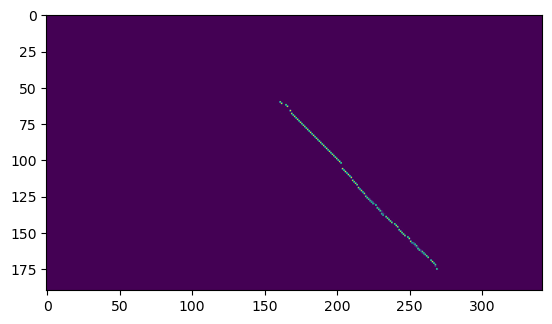

In [45]:
example_alignment = {'query': query,
                     'target': target,
                     'cigar': 0,
                     'qstart': 0,
                     'tstart': 0}
S = np.load("res_lbfgsb.npy")
sw_app = sw(batch=False)
P = sw_app(S, S.shape, gap=-50, temp=11)
print(S.shape)
print(lddt_score_new(example_alignment, sid2coords.get, P)[0])
plt.imshow(P)

In [31]:
example_alignment = {'query': query,
                     'target': target,
                     'cigar': 0,
                     'qstart': 0,
                     'tstart': 0}
S = np.load("res_lbfgsb.npy")
print(S.shape)
sw_app = sw(batch=False)
P = sw_app(S,(S.shape), gap=-5, temp=10)
print(lddt_score_new(example_alignment, sid2coords.get, P)[0])
plt.imshow(P)

(190, 342)


IndexError: index 217 is out of bounds for axis 0 with size 213

In [15]:
lddt_fs = []
lddt_dali = []
lddt_lol = []

for i in tqdm(range(100)):
    q,t = data['query'][i], data['target'][i]
    example_alignment = {'query': q,
                     'target': t,
                     'cigar': data['cigar_fs'][i],
                     'qstart': data['qstart_fs'][i],
                     'tstart': data['tstart_fs'][i]}
    S = np.load("data/100ScoresAnchor/"+q+"-"+t+".npy")
    sw_app = sw(batch=False)
    P = sw_app(S,(S.shape), gap=-5, temp=1)
    #if ((0.1 < P) & (P < 0.9)).sum() != 0:
        #P = calc_fixed_al(P)
    lddt_fs.append(lddt_score(example_alignment, sid2coords.get)[0])
    lddt_lol.append(lddt_score_new(example_alignment, sid2coords.get, P)[0])
    example_alignment = {'query': q,
                    'target': t,
                    'cigar': data['cigar_dali'][i],
                    'qstart': data['qstart_dali'][i],
                    'tstart': data['tstart_dali'][i]}
    
    lddt_dali.append(lddt_score(example_alignment, sid2coords.get)[0])

    
    

  0%|                                                   | 0/100 [00:02<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (161,161) (160,160) 

ValueError: operands could not be broadcast together with shapes (54,54) (80,80) 

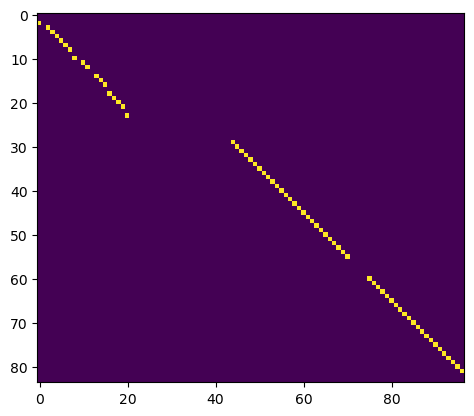

In [15]:
query = 'd2g09a_'
target = 'd2fpra1'
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = np.load("temp.npy")
sw_app = sw(batch=False)
P = sw_app(S.T,(S.T.shape), gap=-5, temp=10)
plt.imshow(P)
lddt_score_new(example_alignment, sid2coords.get, P)[0]


In [63]:
for i in range(100):
    if lddt_lol[i] <=0.2:
        print(data['query'][i], data['target'][i], lddt_lol[i], lddt_dali[i], lddt_fs[i])
    

d1ppjd1 d1c52a_ 0.1988191267392347 0.38876539731078924 0.23905667092599975
d1ufaa2 d2c1ia1 0.16279667484369906 0.49452949127409773 0.3359308758811511
d1uxya1 d1okkd2 0.18773682309240447 0.31772675236512665 0.3425560479266401
d2b6ca1 d2bnxa1 0.19925741181458076 0.43276486427080296 0.36366991141317034


In [19]:
lddt_lol_lbfgsb = []
for i in (range(100)):
    q,t = data['query'][i], data['target'][i]
    S = np.load("data/100ScoresLBFGSB/"+q+"-"+t+".npy")
    print(i, S.shape)


0 (233, 283)
1 (120, 151)
2 (330, 206)
3 (97, 84)
4 (152, 106)
5 (309, 332)
6 (131, 141)
7 (78, 104)
8 (98, 97)
9 (190, 342)
10 (130, 82)
11 (96, 140)
12 (138, 92)
13 (141, 123)
14 (95, 79)
15 (104, 124)
16 (499, 150)
17 (320, 261)
18 (92, 79)
19 (169, 323)
20 (234, 259)
21 (110, 95)
22 (98, 89)
23 (126, 102)
24 (245, 271)
25 (259, 237)
26 (201, 165)
27 (108, 456)
28 (255, 272)
29 (198, 230)
30 (132, 119)
31 (117, 115)
32 (195, 131)
33 (148, 142)
34 (85, 85)
35 (401, 407)
36 (178, 171)
37 (239, 62)
38 (124, 124)
39 (170, 178)
40 (319, 90)
41 (255, 297)
42 (133, 271)
43 (129, 104)
44 (168, 105)
45 (256, 79)
46 (113, 97)
47 (110, 91)
48 (209, 165)
49 (88, 147)
50 (60, 78)
51 (1146, 447)
52 (404, 196)
53 (81, 81)
54 (198, 207)
55 (60, 332)
56 (267, 213)
57 (124, 123)
58 (117, 119)
59 (100, 83)
60 (200, 282)
61 (174, 160)
62 (202, 253)
63 (174, 190)
64 (291, 263)
65 (350, 212)
66 (221, 223)
67 (79, 126)
68 (213, 337)
69 (63, 106)
70 (268, 185)
71 (80, 112)
72 (218, 286)
73 (211, 191)
74 (8

In [21]:
lddt

0.41160711477518924

In [31]:
lddt_lol_lbfgsb = []
for i in (range(100)):
    q,t = data['query'][i], data['target'][i]
    example_alignment = {'query': q,
                     'target': t,
                     'cigar': data['cigar_fs'][i],
                     'qstart': data['qstart_fs'][i],
                     'tstart': data['tstart_fs'][i]}
    S = np.load("data/100ScoresLBFGSB/"+q+"-"+t+".npy")
    sw_app = sw(batch=False)
    P = sw_app(S,S.shape, gap=-5, temp=10)
    #if ((0.2 < P) & (P < 0.6)).sum() != 0:
    #    print(True)
    lddt = lddt_score_new(example_alignment, sid2coords.get, P)[0]
    print(i, q,t,lddt, lddt_dali[i])
    lddt_lol_lbfgsb.append(lddt)

    


0 d1bd0a2 d1ykwa1 0.41160711477518924 0.4387578213559447
1 d1bm9a_ d1ku9a_ 0.5042752621801367 0.5077683971977233
2 d1c4oa1 d1oywa2 0.2559983748432474 0.5447921360452829
3 d1dkza1 d2p06a1 0.50616202694678 0.5626277345268428
4 d1dvoa_ d1s35a1 0.43196398350555865 0.5861372047179826
5 d1ec7a1 d1hjua_ 0.3205213224543256 0.47039794087924863
6 d1eyva_ d1tzva_ 0.8119807553498851 0.809171504074448
7 d1f1sa2 d2omzb_ 0.530602569737887 0.5823474869174019
8 d1g1ca_ d1cs6a1 0.7647481243652264 0.7660889000387786


/home/lasse/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lasse/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9 d1h6ka2 d3gvoa_ nan 0.4087366859203008
10 d1i16a_ d2fcfa1 0.5920910827220137 0.5871942817014352
11 d1iq0a3 d3eera_ nan 0.44779364895772816
12 d1jgsa_ d2pg4a1 0.5933659882105455 0.6688243843549574
13 d1jnra1 d1oe8a1 0.42996586686678406 0.4122981139373917
14 d1ktba1 d1wzaa1 0.5942233926792779 0.5720926706144714
15 d1kv9a1 d1gu2a_ 0.4581451893603846 0.5109185713313399
16 d1ky8a_ d1duvg1 0.28562190341329874 0.3372064505571858
17 d1lucb_ d1rd5a_ 0.2438064894721944 0.4754438327985811
18 d1m70a1 d3cu4a_ 0.4833908618283948 0.5414754068362077
19 d1mkya2 d1n0ua2 0.6219604733077979 0.6630932700637505
20 d1n7ka_ d3qz6a_ 0.5121309768515484 0.5152581297870834
21 d1ncna_ d1fltx_ 0.590401208057721 0.5862685514932922
22 d1ncua_ d1gl4b_ 0.5976626210372123 0.58805939002373
23 d1nj8a1 d1vi2a2 0.3841039333544186 0.4957722902452838
24 d1nkva_ d1nv8a_ 0.45017287096908537 0.5487297707722857
25 d1oaaa_ d2z1na_ 0.6529924669333881 0.6639181663218954
26 d1omra_ d1auib_ 0.5174724063783901 0.5043269036646986
27 d

In [32]:
lddt_lol_lbfgsb  = np.nan_to_num(np.array(lddt_lol_lbfgsb))

Text(0, 0.5, 'LDDT-Score gradient decent alignment')

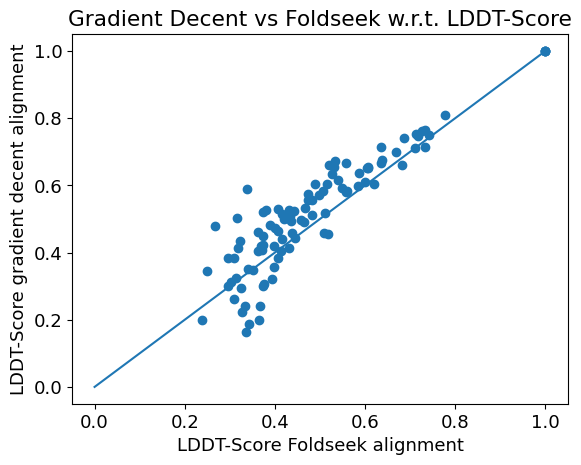

In [28]:
plt.scatter(lddt_fs, lddt_lol)
plt.rcParams.update({'font.size': 13})

plt.plot([0,1],[0,1])
plt.title("Gradient Decent vs Foldseek w.r.t. LDDT-Score")

plt.xlabel("LDDT-Score Foldseek alignment")
plt.ylabel("LDDT-Score gradient decent alignment")

Text(0, 0.5, 'LDDT-Score gradient decent alignment')

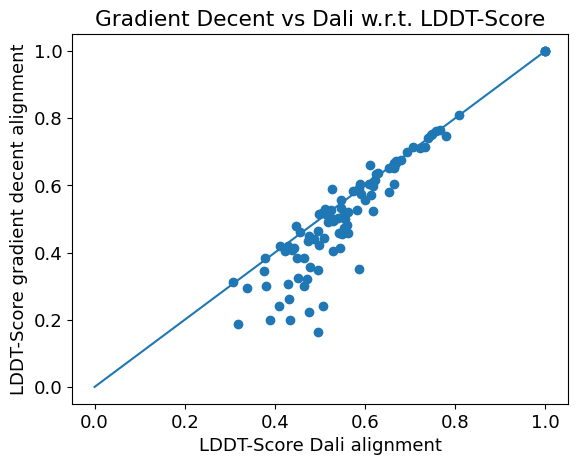

In [29]:
plt.scatter(lddt_dali, lddt_lol)
plt.plot( [0,1],[0,1] )
plt.title("Gradient Decent vs Dali w.r.t. LDDT-Score")
plt.xlabel("LDDT-Score Dali alignment")
plt.ylabel("LDDT-Score gradient decent alignment")

Text(0, 0.5, 'lddt_fs')

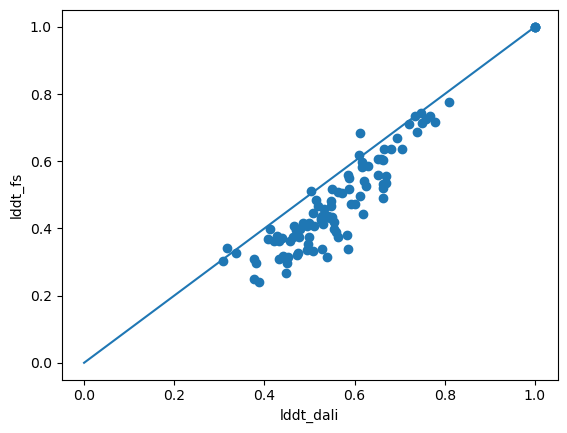

In [66]:
plt.scatter(lddt_dali, lddt_fs)
plt.plot([0,1],[0,1])
plt.xlabel("lddt_dali")
plt.ylabel("lddt_fs")

Text(0, 0.5, 'lol_lol')

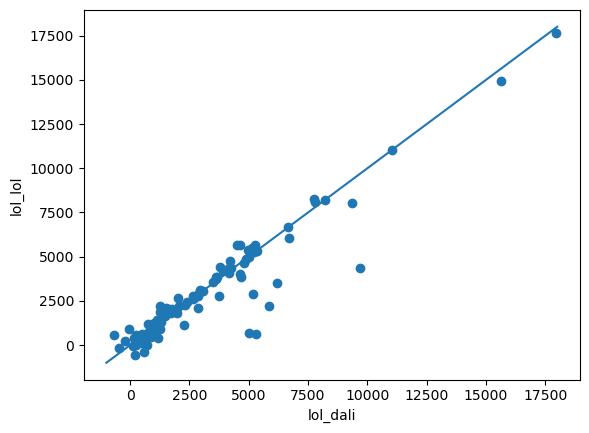

In [67]:
plt.scatter(data['lolscore_dali'],data['lolscore_lol_fixed'])
plt.plot([-1000,18000],[-1000,18000])
plt.xlabel("lol_dali")
plt.ylabel("lol_lol")

Text(0, 0.5, 'lol_lol')

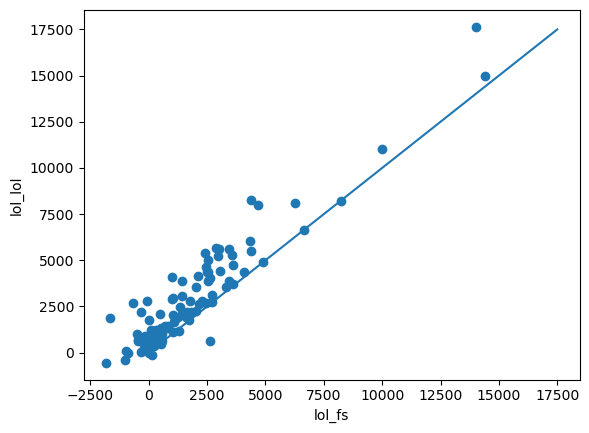

In [16]:
plt.scatter(data['lolscore_fs'],data['lolscore_lol_fixed'])
plt.plot([0,17500],[0,17500] )
plt.xlabel("lol_fs")
plt.ylabel("lol_lol")

Text(0, 0.5, 'lol_fs')

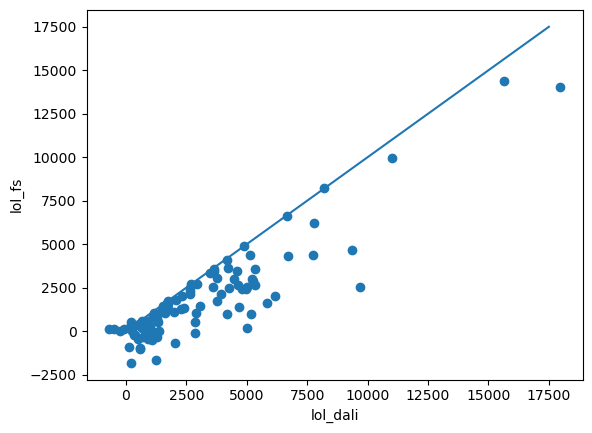

In [68]:
plt.scatter(data['lolscore_dali'],data['lolscore_fs'])
plt.plot([0,17500],[0,17500] )
plt.xlabel("lol_dali")
plt.ylabel("lol_fs")

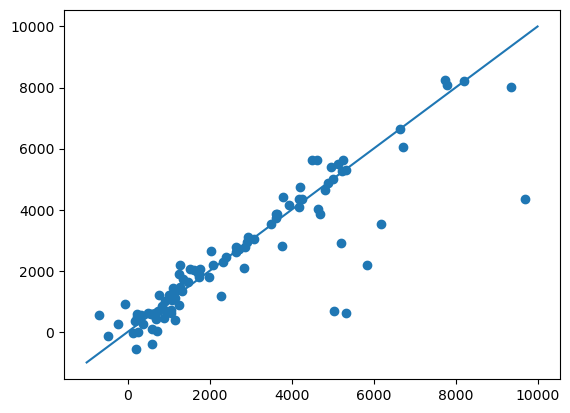

In [63]:
plt.scatter(data['lolscore_dali'][data['lolscore_lol_fixed']<10000],data['lolscore_lol_fixed'][data['lolscore_lol_fixed']<10000])
plt.plot([-1000,10000],[-1000,10000])

Text(0, 0.5, 'LDDT-Score gradient decent alignment')

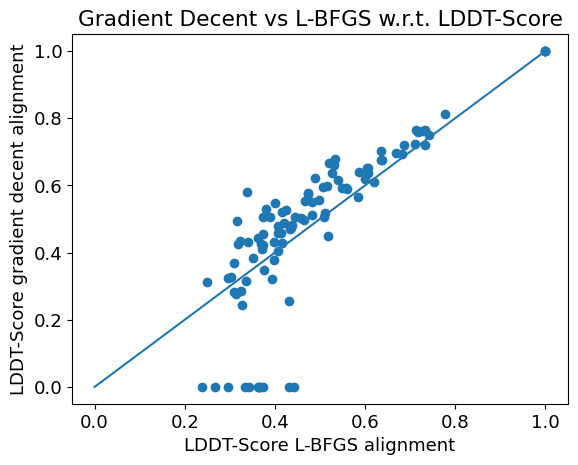

In [33]:
plt.scatter(lddt_fs, lddt_lol_lbfgsb)
plt.plot([0,1],[0,1])
plt.xlabel("lddt_fs")
plt.ylabel("lddt_lbfgsb")

Text(0, 0.5, 'LDDT-Score gradient decent alignment')

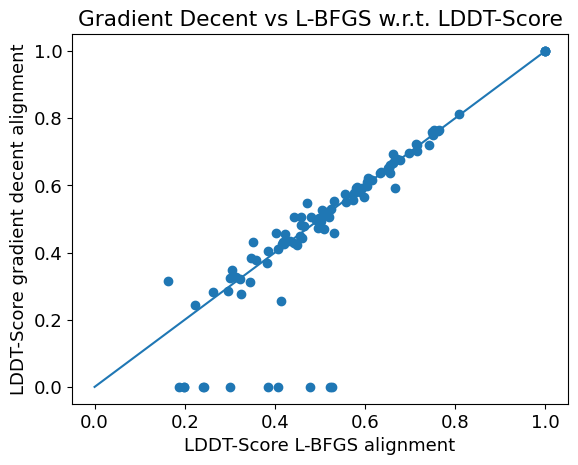

In [34]:
plt.scatter(lddt_lol, lddt_lol_lbfgsb)
plt.plot([0,1],[0,1])
plt.title("Gradient Decent vs L-BFGS w.r.t. LDDT-Score")
plt.xlabel("LDDT-Score L-BFGS alignment")
plt.ylabel("LDDT-Score gradient decent alignment")

In [30]:
plt.scatter(lddt_dali, lddt_lol_lbfgsb)
plt.plot([0,1],[0,1])
plt.xlabel("lddt_lol")
plt.ylabel("lddt_lbfgsb")

NameError: name 'lddt_lol_lbfgsb' is not defined

Text(0, 0.5, 'lolscore_lbfgsb')

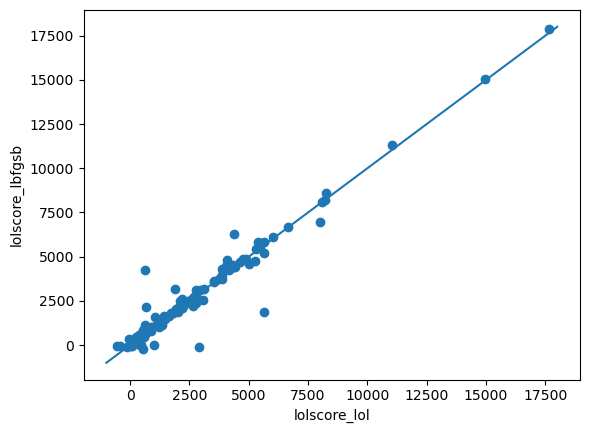

In [17]:
plt.scatter(data['lolscore_lol_fixed'],data['lolscore_lol_lbfgsb'])
plt.plot([-1000,18000],[-1000,18000])
plt.xlabel("lolscore_lol")
plt.ylabel("lolscore_lbfgsb")

In [26]:
lddt_fs = [0.37176026389147315,
 0.4445370238974231,
 0.4305295712130041,
 0.5078462350841817,
 0.33933321987741755,
 0.39373118554079717,
 0.7763582938565646,
 0.38006341013463724,
 0.7337761857475614,
 0.36788707764741724,
 0.5484628618490909,
 0.2680914666439063,
 0.5569855353495645,
 0.39870829667914964,
 0.5060000802281209,
 0.40639406164820646,
 0.3253169000326026,
 0.3279124940272164,
 0.4376729068478308,
 0.4896837558229624,
 0.48316632624530426,
 0.5593378145962705,
 0.5157808231538576,
 0.35216402002507113,
 0.5180564405763212,
 0.6037313690623056,
 0.509973317818912,
 0.43096073305319355,
 0.40766558653172386,
 0.481769078994725,
 0.7426487379197034,
 0.3375335630552968,
 0.23905667092599975,
 0.6682583997094818,
 1.0,
 0.5408320127908491,
 0.4735729549694752,
 0.31362922990374353,
 0.6868879403221291,
 0.5340261484486386,
 0.3082576911597103,
 0.4585074291350827,
 0.3614667957979454,
 0.33255156566796484,
 0.3027034090617449,
 0.3728896086839204,
 0.531367134716288,
 0.6825890416005892,
 0.5574654779719117,
 0.37369865447737427,
 0.7125775445208767,
 0.3758534732458269,
 0.3359308758811511,
 0.7167489192423525,
 0.3425560479266401,
 0.4432756820373128,
 0.2969749689069226,
 0.5989130199727432,
 0.6349618753474147,
 0.7334550350706369,
 0.5863751068429599,
 0.709984387354585,
 0.5264843056184771,
 0.41417607665997946,
 0.2964434445616978,
 0.4163889172863107,
 0.43585806515450626,
 0.31617294355921033,
 0.36366991141317034,
 0.5832680187458146,
 0.3732843973850317,
 0.3737422619793297,
 0.4672556478485809,
 0.6188759449605031,
 0.5208835705383187,
 0.30887258106892,
 0.3970928863942958,
 0.6352527648054,
 0.40577557490923205,
 0.433295594544233,
 0.6053652221528792,
 0.2482526380382946,
 0.4733946251624837,
 0.39956637968766484,
 0.4976200983117577,
 0.3897447111027383,
 1.0,
 0.4199888787945795,
 0.7262884322642215,
 0.32217812598434176,
 1.0,
 0.6069896873781536,
 0.4146973005020185,
 0.6376816661694987,
 1.0,
 0.46516190821138353,
 0.3696711601228276,
 0.3624553127403438,
 0.4256085921594811,
 0.3173416146102]


In [24]:
lddt_dali =[0.4387578213559447,
 0.5077683971977233,
 0.5447921360452829,
 0.5626277345268428,
 0.5861372047179826,
 0.47039794087924863,
 0.809171504074448,
 0.5823474869174019,
 0.7660889000387786,
 0.4087366859203008,
 0.5871942817014352,
 0.44779364895772816,
 0.6688243843549574,
 0.4122981139373917,
 0.5720926706144714,
 0.5109185713313399,
 0.3372064505571858,
 0.4754438327985811,
 0.5414754068362077,
 0.6630932700637505,
 0.5152581297870834,
 0.5862685514932922,
 0.58805939002373,
 0.4957722902452838,
 0.5487297707722857,
 0.6639181663218954,
 0.5043269036646986,
 0.5249466605711994,
 0.495400953676426,
 0.5466833275256454,
 0.7463372163190994,
 0.527021104642562,
 0.38876539731078924,
 0.6937147165872404,
 1.0,
 0.6217943184221398,
 0.5908642009995209,
 0.45140844471684066,
 0.7389322377476311,
 0.6693374943111314,
 0.3772973036990426,
 0.5320295913854882,
 0.4215103560206402,
 0.5071702246832213,
 0.30706096343253136,
 0.47646307288950906,
 0.6635595422277124,
 0.6109816748629859,
 0.6526241279693145,
 0.464054549118959,
 0.7489787990143467,
 0.4286257265643641,
 0.49452949127409773,
 0.7785651332161735,
 0.31772675236512665,
 0.617480476187867,
 0.3806512193899941,
 0.6168684421651288,
 0.7059218071103224,
 0.7334550350706369,
 0.6288622613006667,
 0.7209198497250894,
 0.6249917158348662,
 0.5295959427505931,
 0.44908728543803134,
 0.4859665882670564,
 0.527907872370733,
 0.5389238380728801,
 0.43276486427080296,
 0.6169810478313283,
 0.49835866677483603,
 0.5624479065512554,
 0.5468320574608553,
 0.6093836766505413,
 0.6633083513008415,
 0.4319299489976891,
 0.4777505459944087,
 0.664596973815126,
 0.46506309168296545,
 0.5504800526045952,
 0.652690062759851,
 0.3759599844641116,
 0.6000935744637521,
 0.5531383415182695,
 0.612545280875942,
 0.5597306232856416,
 1.0,
 0.5549539185183292,
 0.7574400091138136,
 0.4731338719626262,
 1.0,
 0.6594150326967553,
 0.4979740361103835,
 0.6804655327135649,
 1.0,
 0.5187789511500907,
 0.4286602737212141,
 0.4558830267794655,
 0.5249123936851751,
 0.44123490074484467]
lddt_dali

[0.4387578213559447,
 0.5077683971977233,
 0.5447921360452829,
 0.5626277345268428,
 0.5861372047179826,
 0.47039794087924863,
 0.809171504074448,
 0.5823474869174019,
 0.7660889000387786,
 0.4087366859203008,
 0.5871942817014352,
 0.44779364895772816,
 0.6688243843549574,
 0.4122981139373917,
 0.5720926706144714,
 0.5109185713313399,
 0.3372064505571858,
 0.4754438327985811,
 0.5414754068362077,
 0.6630932700637505,
 0.5152581297870834,
 0.5862685514932922,
 0.58805939002373,
 0.4957722902452838,
 0.5487297707722857,
 0.6639181663218954,
 0.5043269036646986,
 0.5249466605711994,
 0.495400953676426,
 0.5466833275256454,
 0.7463372163190994,
 0.527021104642562,
 0.38876539731078924,
 0.6937147165872404,
 1.0,
 0.6217943184221398,
 0.5908642009995209,
 0.45140844471684066,
 0.7389322377476311,
 0.6693374943111314,
 0.3772973036990426,
 0.5320295913854882,
 0.4215103560206402,
 0.5071702246832213,
 0.30706096343253136,
 0.47646307288950906,
 0.6635595422277124,
 0.6109816748629859,
 0.652

In [66]:
lddt_lol_3

[]

In [25]:
lddt_lol = [0.3560062849430324,
 0.44186820117517067,
 0.3672893957787498,
 0.4570800257087478,
 0.35188534655204495,
 0.3042934864639669,
 0.8087420650001546,
 0.5251191206221746,
 0.7648456676579086,
 0.2604099907849371,
 0.5927906183356775,
 0.4787430274905845,
 0.6669778503302933,
 0.41872794712371364,
 0.582031431173572,
 0.5301626851598732,
 0.0959757938723593,
 0.17782725505490435,
 0.457479029551877,
 0.5570506949266064,
 0.4441513857822478,
 0.5834702575504271,
 0.603174928681363,
 0.3475639992354786,
 0.5735712536959611,
 0.5905206655278391,
 0.4854344018256169,
 0.24169980172619648,
 0.3676455203985374,
 0.505564901090983,
 0.7496432199298163,
 0.5881756227056713,
 0.18625136731483832,
 0.6979851321078979,
 1.0,
 0.3352972959949552,
 0.5381692206383404,
 0.3252668732367054,
 0.7423090087430358,
 0.6695013170645835,
 0.37695729181491,
 0.5104488118703212,
 0.4058290987727429,
 0.24019156122204505,
 0.31374128101037746,
 0.3433079313933764,
 0.6556865671133814,
 0.6607490103935915,
 0.46549237821259903,
 0.3013562022171358,
 0.7529144299028687,
 0.2534758494036667,
 0.15207509213085804,
 0.7473278879999367,
 0.19572348096674266,
 0.5222666195066608,
 0.2228251662883726,
 0.6090645706904778,
 0.7151921891565931,
 0.7152458113080509,
 0.3970633735155207,
 0.6744801720129888,
 0.5178542169327894,
 0.3785681856727059,
 0.13656675605565302,
 0.42458790137624447,
 0.32813734868898076,
 0.5018893922374243,
 0.18495448698274797,
 0.5972372842578888,
 0.4353456857057112,
 0.5191137780155446,
 0.47028692633841757,
 0.6484176918107435,
 0.6618529902611952,
 0.1194623912665617,
 0.35993207041137476,
 0.6663069845585479,
 0.3842395605934978,
 0.5092528206489849,
 0.6515005285322628,
 0.2146598955647715,
 0.5158402560108645,
 0.3567577457039667,
 0.4567695582967932,
 0.4808392602417946,
 1.0,
 0.4083697368926755,
 0.6137400023908762,
 0.3234151353851387,
 1.0,
 0.6551211617460484,
 0.44707689214919116,
 0.4489388568201785,
 1.0,
 0.3835266235280408,
 0.4206971349280712,
 0.45966850658151354,
 0.39885457293503546,
 0.414595443667758]